In [289]:
from pmda.parallel import ParallelAnalysisBase
import numpy as np
from MDAnalysis import Universe
import MDAnalysis as mda
import warnings
warnings.filterwarnings("ignore")
import sys
import os
membrane_path = os.path.abspath('../membrane')
if membrane_path not in sys.path:
    sys.path.append(membrane_path)
from radii import types_radii2

THERE ARE CHANGES FOR DRUDE. READ COMMENTS IN CODE

In [292]:
class PackingDefect2:
    def __init__(self):
        pass

    def read_top(self, resname, topology_file):
        tails = []
        tails += ['C2%d' %i for i in range(2, 23)]
        tails += ['C3%d' %i for i in range(2, 23)]
        tails += ['H%dR' %i for i in range(2, 23)]
        tails += ['H%dS' %i for i in range(2, 23)]
        tails += ['H%dX' %i for i in range(2, 23)]
        tails += ['H%dY' %i for i in range(2, 23)]
        tails += ['H16Z', 'H18T', 'H91', 'H101', 'H18Z', 'H20T']
        
        #### remove if not Drude
        tails +=['DC']
        TGglyc = ['O11', 'O21', 'O31', 'O12', 'O22', 'O32',
                  'C1', 'C2', 'C3', 'C11', 'C21', 'C31',
                  'HA', 'HB', 'HS', 'HX', 'HY']

        top = open(topology_file)
        startread = False
        output = {}
        for line in top:
            if line.startswith('!'):
                continue
            if line.startswith('RESI {}'.format(resname)):
                startread = True
            if startread and line.startswith('BOND'):
                startread = False
            if startread and line.startswith('ATOM'):
                sl = line.split()

                ### PL headgroup: -1
                ### PL acyl chains: 1
                ### TG glycerol: 2
                ### TG tail cahins: 3
                if resname != 'TRIO':
                    if sl[1] in tails:
                        acyl = 1
                    else:
                        acyl = -1
                else:
                    if sl[1] in TGglyc:
                        acyl = 2
                    else:
                        acyl = 3

                # change here if using different FFs
                output[sl[1]] = [types_radii2[sl[2]], acyl]
        return output


    def defect_size(self, matrices, nbins, bin_max, fname, prob=True):
        bins = np.linspace(0, bin_max, nbins)

        defects = []
        for matrix in matrices:
            graph = self._make_graph(matrix)
            visited = set([])
            for n in graph:
                if n not in visited:
                    defect_loc = self._dfs(graph, n)
                    visited = visited.union(defect_loc)
                    defects.append(len(defect_loc))

        hist, _ = np.histogram(defects, bins)
        hist = hist.astype(np.float64)
        binp = 0.5 * (_[1:] + _[:-1])

        if np.sum(hist) == 0:
            return

        if prob:
            hist /= np.sum(hist)
        
        np.savetxt(fname, np.transpose([binp, hist]), fmt="%8.5f")


    def _dfs(self, graph, start):
        visited, stack = set(), [start]
        while stack:
            vertex = stack.pop()
            if vertex not in visited:
                visited.add(vertex)
                stack.extend(graph[vertex] - visited)
        return visited


    def _make_graph(self, matrix):
        graph = {}
        xis, yis = matrix.shape

        for (xi, yi), value in np.ndenumerate(matrix):
            if value == 0:
                continue

            n = xi * yis + yi
            nlist = []

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    # 8-neighbors
                    x = divmod(xi + dx, xis)[1]
                    y = divmod(yi + dy, yis)[1]
                    if matrix[x, y] == 1:
                        ndn = x * yis + y
                        nlist.append(ndn)

                   # 4 neighbors
                   # if dx * dy == 0:
                   #     x = divmod(xi + dx, xis)[1]
                   #     y = divmod(yi + dy, yis)[1]
                   #     if matrix[x, y] == 1:
                   #         ndn = x * yis + y
                   #         nlist.append(ndn)

            graph[n] = set(nlist) - set([n])
        return graph


class PackingDefect2PMDA(ParallelAnalysisBase):
    def __init__(self, atomgroups, radii, start_frame=0, end_frame=None, nbins=600, bin_max=150, prefix='../output_data/defects/', prob=True):
        os.makedirs(prefix, exist_ok=True)
        u = atomgroups[0].universe
        self.N  = 6000 #The maximum number of defects
        self.dt = u.trajectory[0].dt
        self.dx = 1
        self.dy = 1
        self.radii = radii
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.nbins = nbins
        self.bin_max = bin_max
        self.prefix  = prefix
        self.prob    = prob
#         self.protein_atoms = u.select_atoms("protein")  # Add this line to select protein atoms
        super(PackingDefect2PMDA, self).__init__(u, atomgroups)

    def _prepare(self):
        pass

    def _single_frame(self, ts, atomgroups):
        ag = atomgroups[0]
        dim = ts.dimensions.copy()
        pbc = dim[0:3]
        print('time: {:.3f}    pbc: {:.3f} {:.3f} {:.3f}'.format(ts.time/1000, pbc[0], pbc[1], pbc[2]))
        pbc_xy0 = np.array([pbc[0],pbc[1],0])
        pbc_xyz = np.array([pbc[0],pbc[1],pbc[2]])
        aa = ag.universe.atoms
        aa.positions -= pbc_xy0 * np.floor(aa.positions / pbc_xyz)
        hz = np.average(ag.select_atoms('name P').positions[:,2])

        xarray = np.arange(0, pbc[0], self.dx)
        yarray = np.arange(0, pbc[1], self.dy)
        xx, yy = np.meshgrid(xarray, yarray)

        M = {}; M['up'] = np.zeros_like(xx); M['dw'] = np.zeros_like(xx)
        Z = {}; Z['up'] = np.zeros_like(xx); Z['dw'] = np.zeros_like(xx)
        Z['up'] += hz; Z['dw'] += hz

        zlim = {}
        zlim['up'] = np.max(ag.positions[:,2])
        zlim['dw'] = np.min(ag.positions[:,2])

        PL = {}
        PL['up'] = ag.select_atoms('name P and prop z > %f' %hz).center_of_mass()[2]
        PL['dw'] = ag.select_atoms('name P and prop z < %f' %hz).center_of_mass()[2]

        atoms = {}
        atoms['up'] = ag.select_atoms('prop z > %f' %(PL['up'] - 20))
        atoms['dw'] = ag.select_atoms('prop z < %f' %(PL['dw'] + 20))

        for l in ['up', 'dw']:
            for atom in atoms[l]:
                xatom, yatom, zatom = atom.position
                try:
                    radius, acyl = self.radii[atom.resname][atom.name]
                except KeyError:
                    # Optionally log a warning
                    continue


                if l == 'up': assert zatom > PL[l] - 20, 'check Z pos'
                if l == 'dw': assert zatom < PL[l] + 20, 'check Z pos'

                radius, acyl = self.radii[atom.resname][atom.name]

                dxx =  xx - xatom
                dxx -= pbc[0] * np.around(dxx/pbc[0])

                dyy =  yy - yatom
                dyy -= pbc[1] * np.around(dyy/pbc[1])

                dist_meet = (np.sqrt(self.dx**2 + self.dy**2)/2 + radius)**2
                bAr = dxx ** 2 + dyy ** 2 < dist_meet

                if acyl == -1:
                    M[l][bAr] = acyl
                    continue

                else:
                    bAnP = M[l] >= 0

                    if l == 'up':
                        baZ = zatom > Z[l]
                    else:
                        baZ = zatom < Z[l]

                    bA = bAr & bAnP & baZ
                    M[l][bA] = acyl
                    Z[l][bA] = zatom

        return M['up'], M['dw'], PL['up']+5, PL['dw']-5, dim


    def _conclude(self):
        print("Concluding...")
        Mup = []; Mdw = []; zlimup = []; zlimdw = []; dim = []
        for r in self._results:
            for rr in r:
                Mup.append(rr[0])
                Mdw.append(rr[1])
                zlimup.append(rr[2])
                zlimdw.append(rr[3])
                dim.append(rr[4])

        N  = self.N
        df = Universe.empty(n_atoms = N,
                            n_residues = N,
                            atom_resindex = np.arange(N),
                            residue_segindex = [0] * N,
                            trajectory=True)

        df.add_TopologyAttr('resname', ['O'] * N)
        df.add_TopologyAttr('name',    ['O'] * N)
        df.add_TopologyAttr('resid', np.arange(N) + 1)

        nframes = len(dim)
        fac = np.zeros((nframes, N, 3))
        df.load_new(fac, order='fac')
        df.trajectory[0].dt = self.dt

        for i, ts in enumerate(df.trajectory):
            df.trajectory[i].dimensions = dim[i]

        defects = ['Deep', 'PLacyl', 'TGglyc', 'TGacyl']

        defect_uni = {}; defect_clu = {}
        for d in defects: defect_uni[d] = df.copy()
        for d in defects: defect_clu[d] = []
        defect_thr = {'Deep': 0,  'PLacyl': 1,  'TGglyc': 2,  'TGacyl': 3}

        for d in defects:
            for i, ts in enumerate(defect_uni[d].trajectory):
                num = 0

                bA  = (Mup[i] == defect_thr[d])
                defect_clu[d].append(bA.astype(int))
                ind = np.where(bA)
                xs  = ind[1]; ys = ind[0]

                for x1, y1 in zip(xs, ys):
                    pos = np.array([x1, y1, zlimup[i]])
                    defect_uni[d].atoms[num].position = pos
                    num += 1

                bA = (Mdw[i] == defect_thr[d])
                defect_clu[d].append(bA.astype(int))
                ind = np.where(bA)
                xs = ind[1]; ys = ind[0]

                for x1, y1 in zip(xs, ys):
                    pos = np.array([x1, y1, zlimdw[i]])
                    defect_uni[d].atoms[num].position = pos
                    num += 1

        ### DEFECT LOCALIZATION
        for d in defects:
            u = defect_uni[d]
            u.trajectory[-1]
            u.atoms.write(self.prefix + d + '.gro')
            with mda.Writer(self.prefix + d + '.xtc', u.atoms.n_atoms) as W:
                for ts in u.trajectory:
                    W.write(u.atoms)

        ### DEFECT CLUSTER
        PD = PackingDefect2()
        for d in defects:
            PD.defect_size(defect_clu[d],
                    fname=self.prefix + d + '.dat',
                    nbins=self.nbins,
                    bin_max=self.bin_max,
                    prob=self.prob)

In [301]:
if __name__ == '__main__':

    u = mda.Universe('../../trajs/ld.psf', '../../trajs/st3.dcd')
    pd = PackingDefect2()

    lipid = '../top/top_all36_lipid.rtf'
    TRIO  = '../top/TRIO.rtf'
    SAPI  = '../top/toppar_all36_lipid_inositol.str'
    
    d_lipid = '../top/lipid_drud.str'
    d_TRIO  = '../top/trio_drud.str'

#     radii = {'POPC': pd.read_top('POPC', lipid),
#              'DOPE': pd.read_top('DOPE', lipid),
#              'SAPI': pd.read_top('SAPI', SAPI),
#              'TRIO': pd.read_top('TRIO', TRIO)}
    
    new_radii = {'POPC': pd.read_top('POPC', d_lipid),
             'DOPE': pd.read_top('DOPE', d_lipid),
             'TRIO': pd.read_top('TRIO', d_TRIO)}

    MEMB = u.select_atoms('resname POPC DOPE TRIO')
    output_dir = '../output_data/defects_st3/'
    pdPMDA = PackingDefect2PMDA([MEMB], new_radii, prefix=output_dir)
    pdPMDA.run(n_jobs=12)

/home/jaybraun/miniconda3/lib/python3.9/site-packages/pmda/parallel.py:440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(res), np.asarray(times_io), np.asarray(
/home/jaybraun/miniconda3/lib/python3.9/site-packages/pmda/parallel.py:440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(res), np.asarray(times_io), np.asarray(


time: 103.910    pbc: 98.004 98.004 143.352
time: 103.920    pbc: 98.014 98.014 142.972
time: 103.930    pbc: 98.017 98.017 143.205
time: 103.940    pbc: 97.809 97.809 143.565
time: 103.950    pbc: 97.885 97.885 143.685
time: 103.960    pbc: 98.024 98.024 143.301
time: 103.970    pbc: 98.177 98.177 143.240
time: 103.980    pbc: 97.972 97.972 143.178
time: 103.430    pbc: 98.361 98.361 142.299
time: 103.440    pbc: 98.379 98.379 142.168
time: 103.450    pbc: 98.285 98.285 142.532
time: 103.460    pbc: 98.081 98.081 142.617
time: 103.470    pbc: 98.020 98.020 143.027
time: 103.480    pbc: 98.011 98.011 143.243
time: 103.490    pbc: 97.923 97.923 143.382
time: 103.500    pbc: 97.977 97.977 143.289
time: 104.300    pbc: 98.317 98.317 142.174
time: 104.310    pbc: 98.361 98.361 142.261
time: 104.320    pbc: 98.388 98.388 142.157
time: 104.330    pbc: 98.584 98.584 141.738
time: 104.340    pbc: 98.553 98.553 141.568
time: 104.350    pbc: 98.619 98.619 141.493
time: 104.360    pbc: 98.575 98.

In [302]:

import matplotlib.pyplot as plt

def _dfs(graph, start):
    visited, stack = set(), [start]
    while stack:
        vertex = stack.pop()
        if vertex not in visited:
            visited.add(vertex)
            stack.extend(graph[vertex] - visited)
    return visited


def _make_graph(matrix):
    graph = {}
    xis, yis = matrix.shape

    for (xi, yi), value in np.ndenumerate(matrix):
        if value == 0:
            continue

        n = xi * yis + yi
        nlist = []

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                # 8-neighbors
                x = divmod(xi + dx, xis)[1]
                y = divmod(yi + dy, yis)[1]
                if matrix[x, y] == 1:
                    ndn = x * yis + y
                    nlist.append(ndn)

        graph[n] = set(nlist) - set([n])
    return graph

In [303]:
base_name = 'drude_st3'  # Change this variable to easily switch prefixes
base_dir = f'../output_data/defects_{base_name}'

# Create universes by joining the base directory with specific filenames
u = mda.Universe(f'{base_dir}/PLacyl.gro', f'{base_dir}/PLacyl.xtc')
u2 = mda.Universe(f'{base_dir}/TGacyl.gro', f'{base_dir}/TGacyl.xtc')
u3 = mda.Universe(f'{base_dir}/TGglyc.gro', f'{base_dir}/TGglyc.xtc')

In [304]:
u2.trajectory

<XTCReader ../output_data/defects_drude_st3/TGacyl.xtc with 196 frames of 6000 atoms>

# for plot

In [86]:
def calculate_defects_plot(u):
    defects = []

    u.trajectory[3]
    ag = u.select_atoms('prop z > 0')
    hz = np.average(ag.positions[:,2])
    agup = u.select_atoms('prop z > %f' %hz)
    agdw = u.select_atoms('prop z < %f' %hz)

    plt.scatter(agup.positions[:,0], agup.positions[:,1])

    plt.axis('square')
    plt.ylim(0,100)
    plt.xlim(0,100)

    xarray = np.arange(0, u.dimensions[0], 1)
    yarray = np.arange(0, u.dimensions[1], 1)
    xx, yy = np.meshgrid(xarray, yarray)
    Mup = np.zeros_like(xx)
    Mdw = np.zeros_like(xx)

    xind = agup.positions[:,0].astype(np.int64)
    yind = agup.positions[:,1].astype(np.int64)

    Mup[xind, yind] = 1

    graph = _make_graph(Mup)
    visited = set([])
    for n in graph:
        if n not in visited:
            defect_loc = _dfs(graph, n)
            visited = visited.union(defect_loc)
            defects.append(len(defect_loc))
            
    return defects



# For calculating constant

Function calculate_defects(u)
    Initialize an empty list `defects` to store the sizes of all detected defects

    # Iterate over each frame in the trajectory
    For each frame `ts` in `u.trajectory`
        # Select atoms with positive z-coordinate
        Select atoms `ag` with 'prop z > 0'
        
        # Calculate the average z-coordinate from `ag`
        Calculate average z-coordinate `hz`
        
        # Select atoms above and below the horizontal plane at `hz`
        Select atoms `agup` with 'prop z > hz'
        Select atoms `agdw` with 'prop z < hz'

        # Initialize grids for spatial mapping
        Create arrays `xarray` and `yarray` based on the x- and y-dimensions of the current frame
        Create 2D grids `xx` and `yy` using `xarray` and `yarray`
        Initialize zero matrices `Mup` and `Mdw` with the same shape as `xx`

        # Map the positions of atoms in `agup` to grid `Mup`
        Convert `agup` x- and y-coordinates to integer grid indices `xind` and `yind`
        Mark corresponding indices in `Mup` as 1

        # Map the positions of atoms in `agdw` to grid `Mdw`
        Convert `agdw` x- and y-coordinates to integer grid indices `xind` and `yind`
        Mark corresponding indices in `Mdw` as 1

        # Detect defects in the "up" region
        Create graph `graph_up` from `Mup`
        Initialize an empty set `visited_up`
        For each node `n` in `graph_up`
            If `n` is not in `visited_up`
                Perform Depth-First Search to find a connected cluster `defect_loc`
                Mark all nodes in `defect_loc` as visited
                Append the size of `defect_loc` to `defects`

        # Detect defects in the "down" region
        Create graph `graph_dw` from `Mdw`
        Initialize an empty set `visited_dw`
        For each node `n` in `graph_dw`
            If `n` is not in `visited_dw`
                Perform Depth-First Search to find a connected cluster `defect_loc`
                Mark all nodes in `defect_loc` as visited
                Append the size of `defect_loc` to `defects`

    Return the list `defects`


In [296]:
def calculate_defects(u):
    defects=[]
    for ts in u.trajectory:
        ag = u.select_atoms('prop z > 0')
        hz = np.average(ag.positions[:,2])
        agup = u.select_atoms('prop z > %f' %hz)
        agdw = u.select_atoms('prop z < %f' %hz)

        xarray = np.arange(0, u.dimensions[0], 1)
        yarray = np.arange(0, u.dimensions[1], 1)
        xx, yy = np.meshgrid(xarray, yarray)
        Mup = np.zeros_like(xx)
        Mdw = np.zeros_like(xx)


        ### UP
        xind = agup.positions[:,0].astype(np.int64)
        yind = agup.positions[:,1].astype(np.int64)
        Mup[xind, yind] = 1

        graph = _make_graph(Mup)
        visited = set([])
        for n in graph:
            if n not in visited:
                defect_loc = _dfs(graph, n)
                visited = visited.union(defect_loc)
                defects.append(len(defect_loc))


        ### DW  
        xind = agdw.positions[:,0].astype(np.int64)
        yind = agdw.positions[:,1].astype(np.int64)
        Mdw[xind, yind] = 1

        graph = _make_graph(Mdw)
        visited = set([])
        for n in graph:
            if n not in visited:
                defect_loc = _dfs(graph, n)
                visited = visited.union(defect_loc)
                defects.append(len(defect_loc))
                
    return defects
        


In [305]:
defects_PLacyl = calculate_defects(u)
defects_TGacyl = calculate_defects(u2)
defects_TGglyc = calculate_defects(u3)

In [298]:
import numpy as np
import matplotlib.pyplot as plt

def plot_defect_data(file_paths, labels, colors, markers, output_path=None, title=None):
    plt.figure(figsize=(5, 3))

    # Iterate through each dataset to plot
    for file_path, label, color, marker in zip(file_paths, labels, colors, markers):
        data = np.loadtxt(file_path)
        plt.scatter(data[:, 0], data[:, 1], color=color, marker=marker, label=label, alpha=0.7)

    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    # Add labels, legend, and title
    plt.xlabel('Defect size')
    plt.ylabel('Probability')
    plt.title(title)
    plt.legend()

    if output_path:
        plt.savefig(output_path)
        print(f'Plot saved as {output_path}')
    else:
        plt.show()

# Example usage:


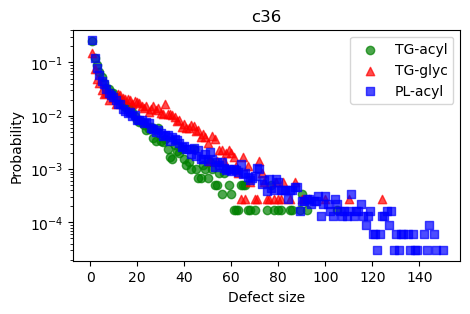

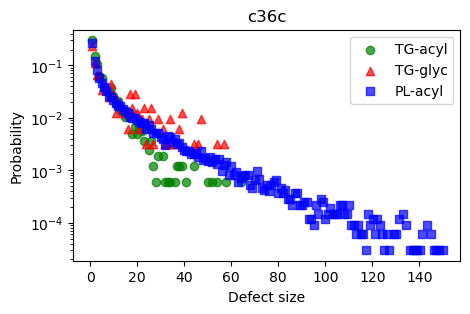

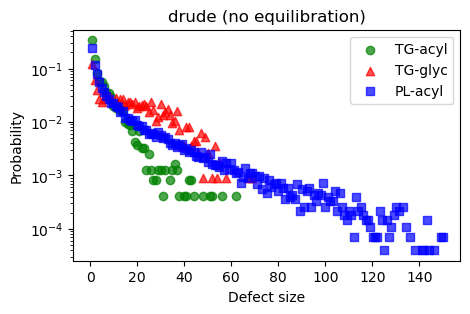

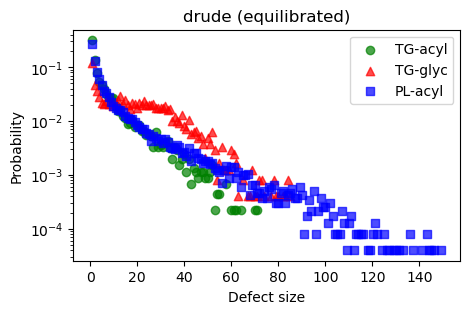

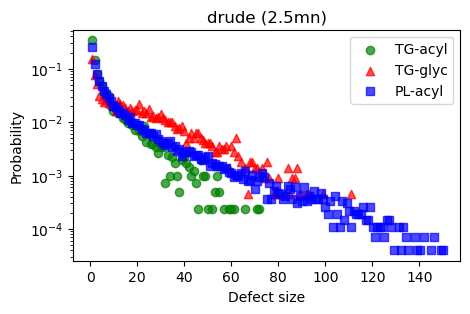

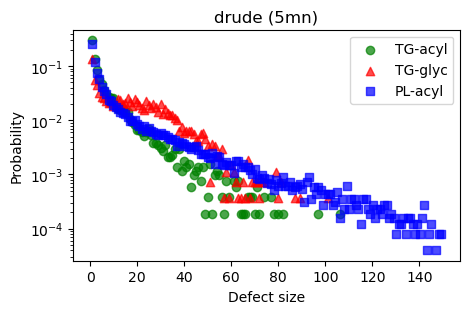

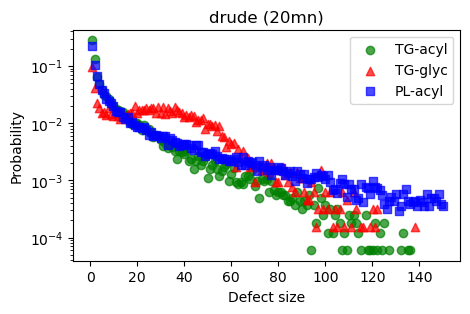

In [306]:
plot_defect_data(
    file_paths=[
        '../output_data/defects_c36/TGacyl.dat',
        '../output_data/defects_c36/TGglyc.dat',
        '../output_data/defects_c36/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='c36',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_c36c/TGacyl.dat',
        '../output_data/defects_c36c/TGglyc.dat',
        '../output_data/defects_c36c/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='c36c',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_drude_no_eq/TGacyl.dat',
        '../output_data/defects_drude_no_eq/TGglyc.dat',
        '../output_data/defects_drude_no_eq/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='drude (no equilibration)',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_drude_eq/TGacyl.dat',
        '../output_data/defects_drude_eq/TGglyc.dat',
        '../output_data/defects_drude_eq/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='drude (equilibrated)',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_drude_st3/TGacyl.dat',
        '../output_data/defects_drude_st3/TGglyc.dat',
        '../output_data/defects_drude_st3/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='drude (2.5mn)',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_drude_st5/TGacyl.dat',
        '../output_data/defects_drude_st5/TGglyc.dat',
        '../output_data/defects_drude_st5/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='drude (5mn)',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)
plot_defect_data(
    file_paths=[
        '../output_data/defects_drude_20mn/TGacyl.dat',
        '../output_data/defects_drude_20mn/TGglyc.dat',
        '../output_data/defects_drude_20mn/PLacyl.dat'
    ],
    labels=['TG-acyl', 'TG-glyc', 'PL-acyl'],
    colors=['green', 'red', 'blue'],
    markers=['o', '^', 's'],
    title='drude (20mn)',
    output_path=None  # Replace with a filename like 'scatter_plot.png' to save the plot
)



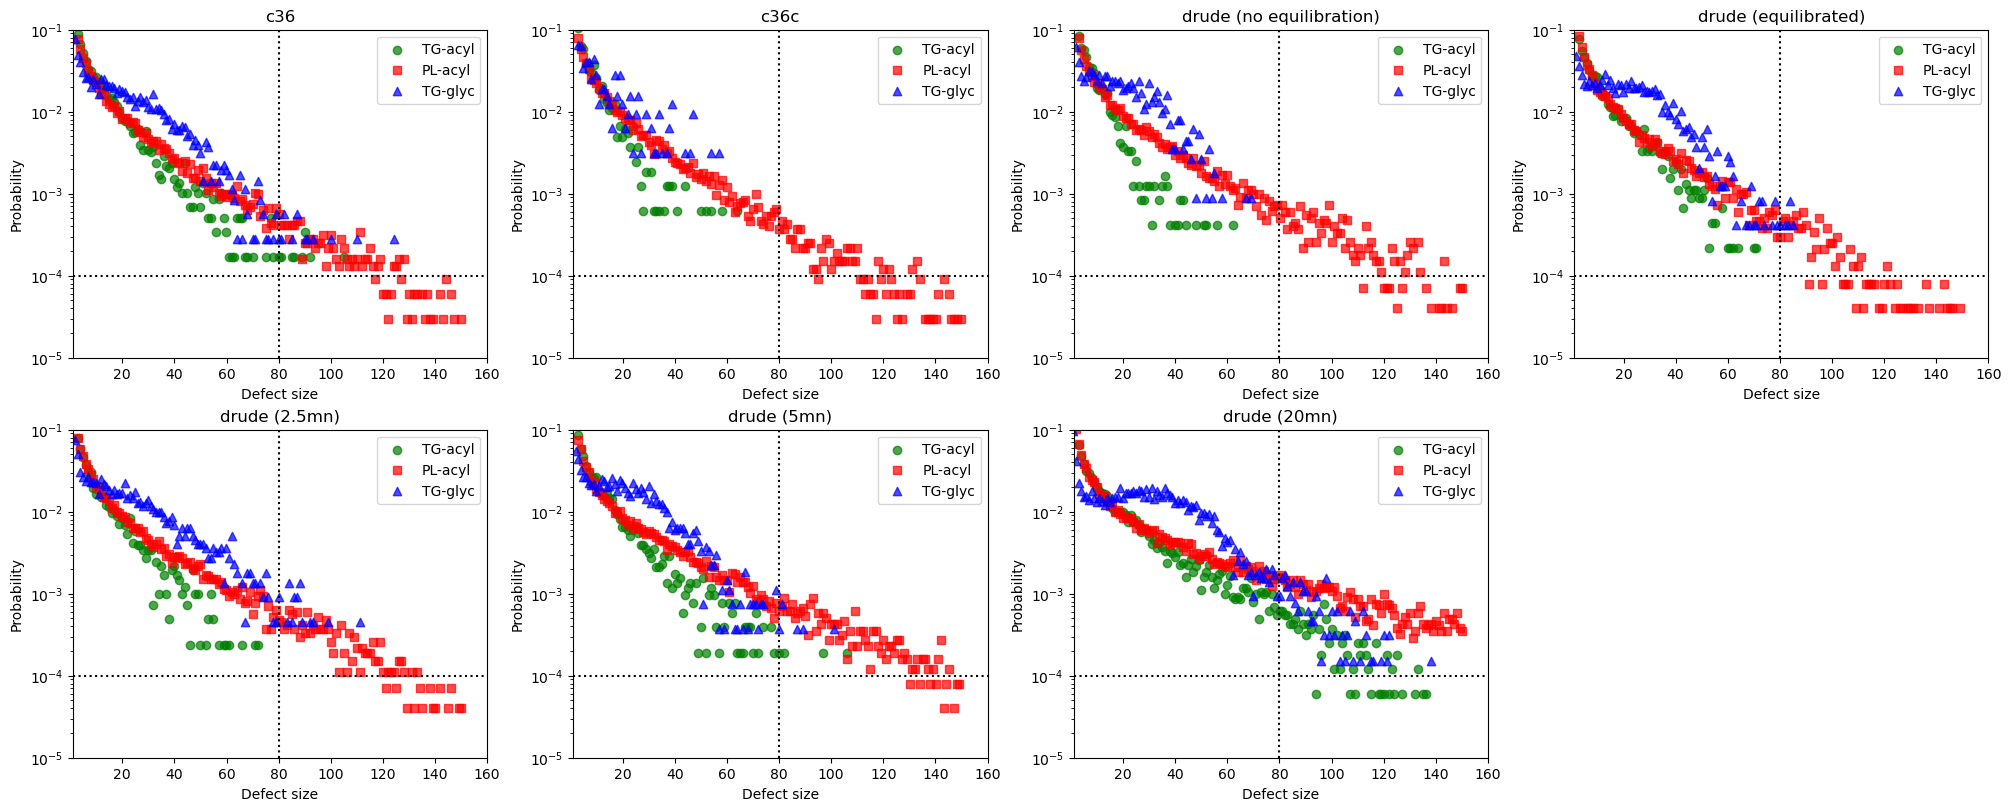

In [307]:
def plot_multiple_defects(subplots_data, figsize=(20, 10), ncols=4):
    """
    Create multiple defect plots as subplots, ensuring TG-glyc is plotted last in blue.

    Parameters:
    - subplots_data (list): List of dictionaries, each containing parameters:
        - 'file_paths' (list): List of file paths containing defect data.
        - 'labels' (list): List of labels corresponding to each data file.
        - 'colors' (list): List of colors for each dataset's plot points.
        - 'markers' (list): List of marker styles for each dataset's plot points.
        - 'title' (str): Title of each subplot.
    - figsize (tuple): Size of the entire figure.
    - ncols (int): Number of columns in the subplot grid.

    Returns:
    - None
    """
    # Determine the number of rows required
    n_plots = len(subplots_data)
    nrows = (n_plots + ncols - 1) // ncols

    # Initialize a figure and set of subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)

    # Flatten axs array for easier indexing
    axs = axs.flatten()

    for i, subplot_data in enumerate(subplots_data):
        ax = axs[i]

        tg_glyc_data = None
        tg_glyc_marker = '^'
        
        # Plot all datasets except TG-glyc first
        for file_path, label, color, marker in zip(subplot_data['file_paths'], subplot_data['labels'], subplot_data['colors'], subplot_data['markers']):
            data = np.loadtxt(file_path)
            if label == 'TG-glyc':
                tg_glyc_data = data
                tg_glyc_marker = marker  # Capture the marker style for TG-glyc
            else:
                ax.scatter(data[:, 0], data[:, 1], color=color, marker=marker, label=label, alpha=0.7)

        # Plot TG-glyc data last with blue color
        if tg_glyc_data is not None:
            ax.scatter(tg_glyc_data[:, 0], tg_glyc_data[:, 1], color='blue', marker=tg_glyc_marker, label='TG-glyc', alpha=0.7)

        ax.set_yscale('log')
        ax.set_ylim(1e-5, 1e-1)
        ax.set_xlim(1,160)
        ax.set_xlabel('Defect size')
        ax.set_ylabel('Probability')
        ax.legend()
        ax.set_title(subplot_data['title'])

        # Add dotted vertical and horizontal reference lines
        ax.axvline(x=80, linestyle=':', color='black')
        ax.axhline(y=1e-4, linestyle=':', color='black')

    # Hide any unused subplot axes
    for i in range(n_plots, len(axs)):
        fig.delaxes(axs[i])
        
    plt.savefig('../output_data/defect.png')

    plt.show()

# Example usage with provided data:
plot_multiple_defects([
    {
        'file_paths': [
            '../output_data/defects_c36/TGacyl.dat',
            '../output_data/defects_c36/TGglyc.dat',
            '../output_data/defects_c36/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'c36'
    },
    {
        'file_paths': [
            '../output_data/defects_c36c/TGacyl.dat',
            '../output_data/defects_c36c/TGglyc.dat',
            '../output_data/defects_c36c/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'c36c'
    },
    {
        'file_paths': [
            '../output_data/defects_drude_no_eq/TGacyl.dat',
            '../output_data/defects_drude_no_eq/TGglyc.dat',
            '../output_data/defects_drude_no_eq/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'drude (no equilibration)'
    },
    {
        'file_paths': [
            '../output_data/defects_drude_eq/TGacyl.dat',
            '../output_data/defects_drude_eq/TGglyc.dat',
            '../output_data/defects_drude_eq/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'drude (equilibrated)'
    },
    {
        'file_paths': [
            '../output_data/defects_drude_st3/TGacyl.dat',
            '../output_data/defects_drude_st3/TGglyc.dat',
            '../output_data/defects_drude_st3/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'drude (2.5mn)'
    },
    {
        'file_paths': [
            '../output_data/defects_drude_st5/TGacyl.dat',
            '../output_data/defects_drude_st5/TGglyc.dat',
            '../output_data/defects_drude_st5/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'drude (5mn)'
    },
    {
        'file_paths': [
            '../output_data/defects_drude_20mn/TGacyl.dat',
            '../output_data/defects_drude_20mn/TGglyc.dat',
            '../output_data/defects_drude_20mn/PLacyl.dat'
        ],
        'labels': ['TG-acyl', 'TG-glyc', 'PL-acyl'],
        'colors': ['green', 'blue', 'red'],
        'markers': ['o', '^', 's'],
        'title': 'drude (20mn)'
    }
], ncols=4, figsize=(20, 8))


In [181]:
xlim = 0
ylim = 1e-5
def fitting(dat):
    x = dat[:, 0]
    y = dat[:, 1]
    valid_mask = (x > xlim) & (y > ylim) & (y > 0)
    newx = x[valid_mask]
    newy = y[valid_mask]

    if len(newx) > 0 and len(newy) > 0:
        a, b = np.polyfit(newx, np.log(newy), 1)
        return a, b, x[y > 0], y[y > 0]
    else:
        return None, None, [], []

def calculate_defect_constants(defects):
    h, bin_edges = np.histogram(defects, bins=np.linspace(0, 150, 600))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    data = np.column_stack((bin_centers, h))
    
    # Plot the histogram
    plt.bar(bin_centers, h, width=0.25, alpha=0.7, color='blue', label='Defect Sizes')
    plt.xlabel('Defect Size')
    plt.ylabel('Count')
    plt.title('Histogram of Defect Sizes')
    plt.yscale('log')
    plt.legend()
    plt.show()

    
    a, b, plotx, ploty = fitting(data)
    if a is not None:
        return -1 / a
    else:
        return None


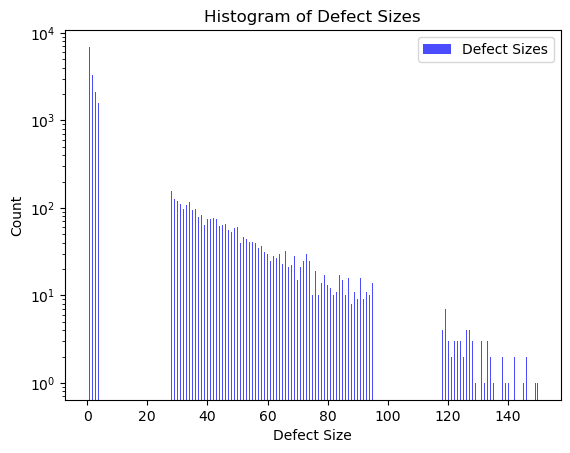

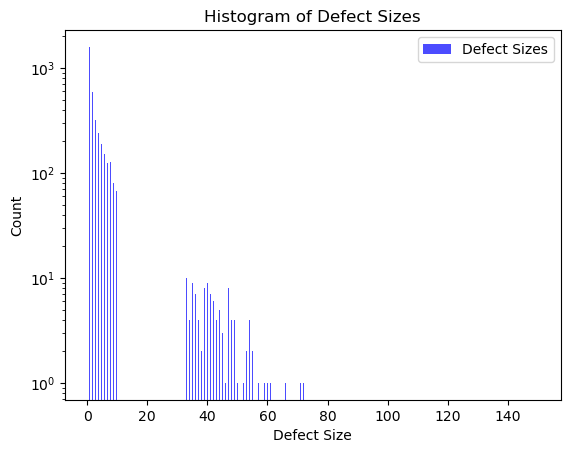

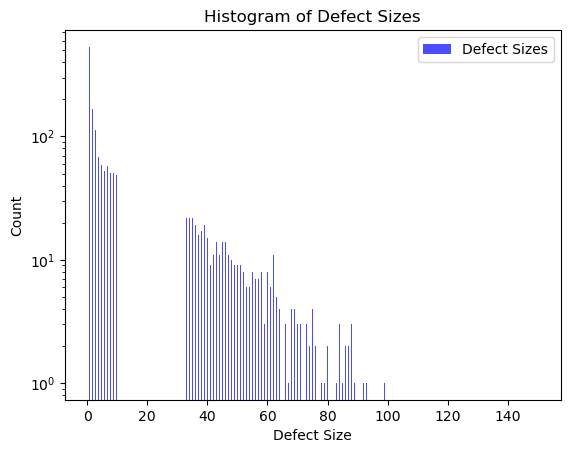

[22.321334196201434, 11.078606431067024, 20.450778630562663]


TypeError: 'tuple' object is not callable

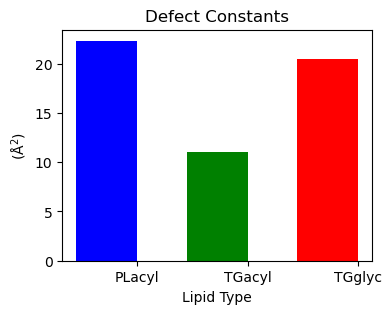

In [308]:

# Your calculated constants
PLacyl_constant = calculate_defect_constants(defects_PLacyl) 
TGacyl_constant = calculate_defect_constants(defects_TGacyl) or 0
TGglyc_constant = calculate_defect_constants(defects_TGglyc) or 0

# Bar plot setup
labels = ['PLacyl', 'TGacyl', 'TGglyc']
constants = [PLacyl_constant, TGacyl_constant, TGglyc_constant]
print(constants)

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 3))
# Specify colors for each bar here
colors = ['blue', 'green', 'red']
rects1 = ax.bar(x - width/2, constants, width, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Lipid Type')
ax.set_ylabel('($\mathregular{\AA^2}$)')
ax.set_title('Defect Constants')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.ylim(0,30)
fig.tight_layout()
# plt.savefig('constants.png',dpi=400)

plt.show()


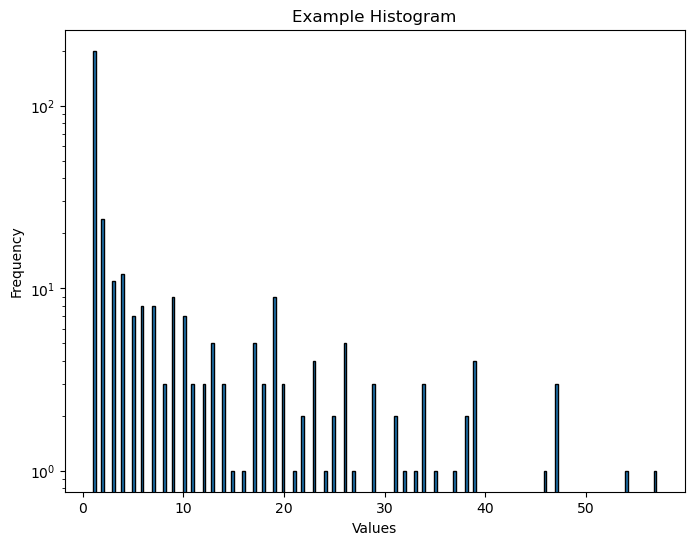

In [277]:
import matplotlib.pyplot as plt

def plot_histogram(data, bins=10, title='Histogram', xlabel='Value', ylabel='Frequency', output_path=None):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if output_path:
        plt.savefig(output_path)
        print(f'Histogram saved to {output_path}')
    else:
        plt.show()

# Example usage:

plot_histogram(defects_TGglyc, bins=200, title='Example Histogram', xlabel='Values', ylabel='Frequency')


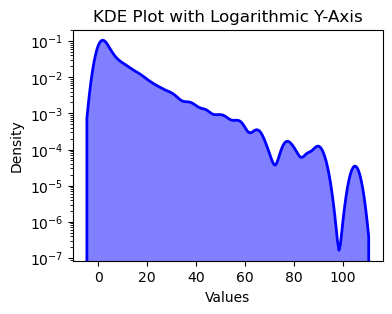

In [287]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde(data, title='KDE Plot', xlabel='Value', ylabel='Density', output_path=None, log_y=False):
    plt.figure(figsize=(4, 3))
    sns.kdeplot(data, fill=True, color='blue', alpha=0.5, linewidth=2)

    if log_y:
        plt.yscale('log')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if output_path:
        plt.savefig(output_path)
        print(f'KDE plot saved to {output_path}')
    else:
        plt.show()

# Example usage:

plot_kde(defects_TGacyl, title='KDE Plot with Logarithmic Y-Axis', xlabel='Values', ylabel='Density', log_y=True)


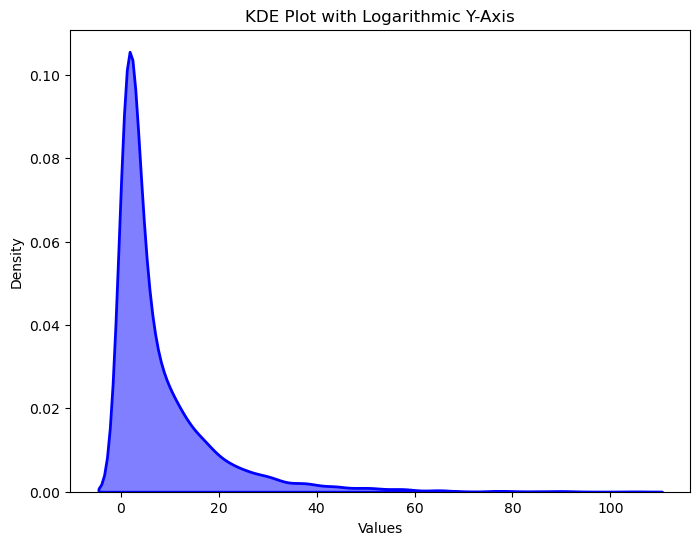

In [284]:
plot_kde(defects_TGacyl, title='KDE Plot with Logarithmic Y-Axis', xlabel='Values', ylabel='Density', log_y=False)

# Block averaging

In [157]:
def split(whole, x):
    a = list(whole)
    chunk_size = max(1, len(a) // x)
    chunks = [a[i:i + chunk_size] for i in range(0, len(a), chunk_size)]
    return chunks

#     for chunk in a:
#         split chunk to () pieces
#         return split pieces

# def calculate defect constant()
#     calculate defect constant
#     return defect constant
    
# for piece in split() of whole thing:
#     calculate defect constant()
    


In [159]:
s = split(defects_PLacyl, 5)